# Ramp rates near startup/shutdown
In the previous notebook I made a method to pick out downtime events. The next step is to calculate a distance, in hours, from each generation value to the previous startup and next shutdown. Then I can characterize startup/shutdown ramps vs 'normal' ramps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.load_dataset import load_epacems
from src.features.build_features import _find_uptime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
idx = pd.IndexSlice

In [4]:
# all states, 1 year
cols = ['operating_datetime_utc', 'operating_time_hours', 'gross_load_mw', 'unit_id_epa']
cems = load_epacems(states=None, years=[2019], columns=cols, engine='pandas')

In [5]:
%%time
cems.sort_values(by=['unit_id_epa', 'operating_datetime_utc'], inplace=True)
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=False, inplace=True)#, verify_integrity=True)

CPU times: user 11.5 s, sys: 3.12 s, total: 14.6 s
Wall time: 14.7 s


In [6]:
cems.sample(3)

,,operating_datetime_utc,operating_time_hours,gross_load_mw,unit_id_epa
unit_id_epa,operating_datetime_utc,,,,
4266,2019-07-20 01:00:00+00:00,2019-07-20 01:00:00+00:00,0.15,1.0,4266
2920,2019-02-20 08:00:00+00:00,2019-02-20 08:00:00+00:00,1.00,175.0,2920
2836,2019-06-01 23:00:00+00:00,2019-06-01 23:00:00+00:00,0.00,0.0,2836


In [7]:
units = cems.groupby(level=['unit_id_epa'])

In [8]:
cems['load_factor'] = units['gross_load_mw'].transform(lambda x: x.div(x.max()))
#cems['load_factor'] = units['gross_load_mw'].transform(lambda x: x.div(x[x>0].quantile(0.99)))

## Distance to startup/shutdown
For all non-zero generation, I want to calculate the hours since last startup and hours to next shutdown. Strategy is to make new columns with the nearest startup/shutdown timestamps and then subtract the index timestamps.

This duplicates the event finding, but it is much faster than processing the events dataframe due to horribly slow assignment in pandas. Maybe there is a way to reuse it, but that's a job for later.

In [9]:
cems['binarized'] = cems['gross_load_mw'].gt(0).astype(np.int8)

In [10]:
cems['binary_diffs'] = cems['binarized'].diff().where(cems['unit_id_epa'].diff().eq(0)) # dont take diffs across units
# this could be done with groupby but it is much slower
# cems.groupby(level='unit_id_epa')['binarized'].transform(lambda x: x.diff())

In [11]:
del cems['binarized']

In [12]:
cems['shutdowns'] = cems['operating_datetime_utc'].where(cems['binary_diffs'] == -1, pd.NaT)

In [13]:
cems['startups'] = cems['operating_datetime_utc'].where(cems['binary_diffs'] == 1, pd.NaT)

Startups and shutdowns do not select the bounds of a production period, they mark the first values of a period of uptime or downtime. `binary_diff == -1` selects the first zero value of a downtime period, while `binary_diff == -1` selects the first non-zero value of an uptime period.

This is a good thing: ramp rates use the same differencing logic, so are defined *between* two periods, not at either of them. At first I shifted startups to indicate the last zero value before uptime, but then found that my ramp rates were defined asymmetrically: ramps at shutdown were non-zero but ramps at startup were zero.

In [14]:
# This line shifts startup indicators to indicate the last zero value instead of the first non-zero value.
# This makes sense for summarizing downtime events, but does not make sense for analyzing differences, like ramp rates.

# cems['startups'] = cems['operating_datetime_utc'].where(cems['binary_diffs'].shift(-1).eq(1) & cems['unit_id_epa'].diff(-1).eq(0), pd.NaT)

In [15]:
del cems['binary_diffs']

### Calculate distances

In [16]:
# fill startups forward and shutdowns backward
cems['startups'] = cems.groupby(level='unit_id_epa')['startups'].transform(lambda x: x.fillna(method='ffill'))
cems['shutdowns'] = cems.groupby(level='unit_id_epa')['shutdowns'].transform(lambda x: x.fillna(method='bfill'))

In [17]:
cems['hours_from_startup'] = cems['operating_datetime_utc'].sub(cems['startups']).dt.total_seconds().div(3600).astype(np.float32)
# invert sign so distances are all positive
cems['hours_to_shutdown'] = cems['shutdowns'].sub(cems['operating_datetime_utc']).dt.total_seconds().div(3600).astype(np.float32)

In [18]:
cems.drop(columns=['startups', 'shutdowns', 'operating_datetime_utc'], inplace=True)

In [19]:
cems.sample(5)

,,operating_time_hours,gross_load_mw,unit_id_epa,load_factor,hours_from_startup,hours_to_shutdown
unit_id_epa,operating_datetime_utc,,,,,,
3674,2019-11-13 04:00:00+00:00,0.0,0.0,3674,NaN,NaN,NaN
4216,2019-06-06 10:00:00+00:00,0.0,0.0,4216,0.000000,110.0,14.0
8288,2019-08-07 23:00:00+00:00,1.0,59.0,8288,0.766234,327.0,390.0
90570,2019-01-12 08:00:00+00:00,0.0,0.0,90570,0.000000,NaN,776.0
4126,2019-09-15 00:00:00+00:00,0.0,0.0,4126,0.000000,80.0,50.0


## Ramp Rate Analysis
To examine ramp rates vs proximity to startup/shutdown times, I'll look at the max ramps binned by distance.

In [20]:
cems['ramp_rate'] = cems.groupby(level='unit_id_epa')['gross_load_mw'].transform(lambda x: x.diff())

In [21]:
cems['ramp_factor'] = cems.groupby(level='unit_id_epa')['load_factor'].transform(lambda x: x.diff())

In [22]:
cems['min_dist_bins'] = pd.cut(cems[['hours_from_startup', 'hours_to_shutdown']].min(axis=1), bins=list(range(-1,10)) + [np.inf])

In [23]:
cems['abs_ramp_factor'] = cems['ramp_factor'].abs()

In [24]:
max_ramps = cems.rename(columns={'unit_id_epa': 'unit'}).groupby(['unit', 'min_dist_bins'])['abs_ramp_factor'].max()

In [25]:
max_ramps = max_ramps[max_ramps != 0].reset_index() # drop empty generators

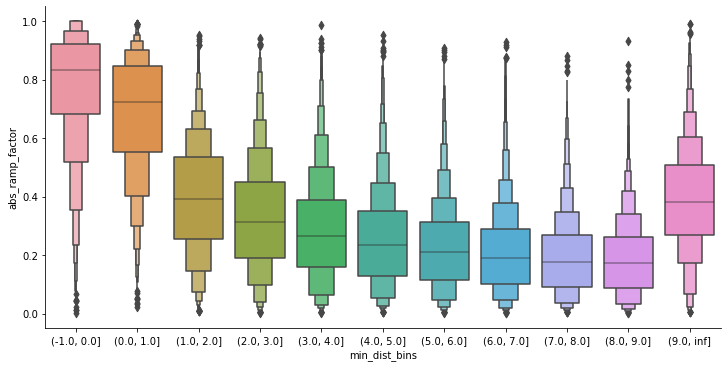

In [26]:
# Distribution of MAXIMUM ramp factor faceted by distance from startup/shutdown
sns.catplot(data=max_ramps, x='min_dist_bins', y='abs_ramp_factor', kind="boxen", aspect=2)

<AxesSubplot:title={'center':'Counts by distance from startup/shutdown'}, xlabel='min_dist_bins'>

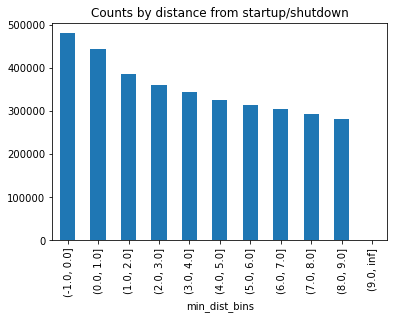

In [27]:
# the bin (9, np.inf] has 28 million records
cems[cems['min_dist_bins'] < pd.Interval(9, np.inf)].groupby('min_dist_bins').size().plot.bar(title="Counts by distance from startup/shutdown")

In [47]:
cems.groupby('min_dist_bins').size()

min_dist_bins
(-1.0, 0.0]      480093
(0.0, 1.0]       443002
(1.0, 2.0]       385692
(2.0, 3.0]       359614
(3.0, 4.0]       342856
(4.0, 5.0]       325831
(5.0, 6.0]       313508
(6.0, 7.0]       303837
(7.0, 8.0]       292426
(8.0, 9.0]       280127
(9.0, inf]     28711869
dtype: int64

Are ramps symmetrical between startup/shutdown?

In [28]:
cems['is_startup'] = cems['hours_from_startup'] < cems['hours_to_shutdown']

In [29]:
# randomly allocate midpoints
rng = np.random.default_rng(seed=2)
rand_midpoints = (cems['hours_from_startup'] == cems['hours_to_shutdown']) & rng.choice(np.array([True, False]), size=len(cems))
cems.loc[rand_midpoints, 'is_startup'] = True

In [30]:
del rand_midpoints

In [31]:
max_ramps = cems.rename(columns={'unit_id_epa': 'unit'}).groupby(['unit', 'min_dist_bins', 'is_startup'])['abs_ramp_factor'].max()

In [32]:
max_ramps = max_ramps[max_ramps != 0].reset_index() # drop empty generators

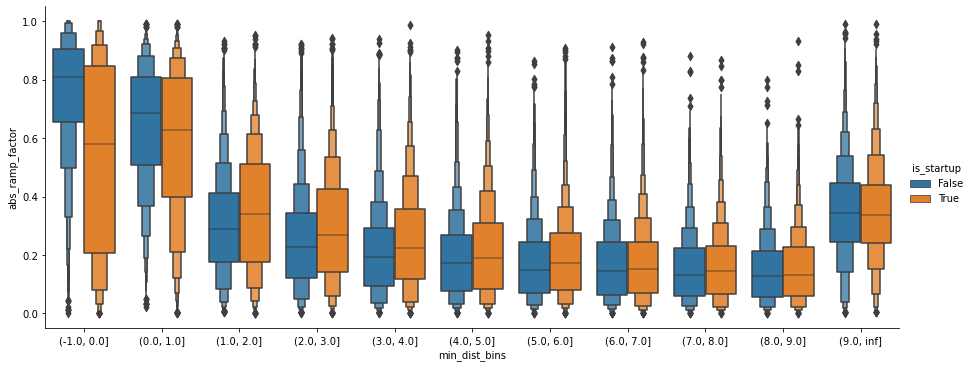

In [33]:
# Distribution of MAXIMUM ramp factor faceted by distance from startup/shutdown
sns.catplot(data=max_ramps, x='min_dist_bins', y='abs_ramp_factor', hue='is_startup', kind="boxen", aspect=2.5)

## Uptime Analysis

In [34]:
event_dfs = []
for grp, df in units['gross_load_mw']:
    event_dfs.append(_find_uptime(df, multiindex_key=grp))
events = pd.concat(event_dfs)
del event_dfs

In [35]:
events

startup                  shutdown
unit_id_epa event                                                    
1           0     2019-03-03 03:00:00+00:00 2019-03-03 09:00:00+00:00
            1     2019-03-04 18:00:00+00:00 2019-03-08 18:00:00+00:00
            2     2019-05-18 18:00:00+00:00 2019-05-30 05:00:00+00:00
            3     2019-07-10 11:00:00+00:00 2019-07-18 04:00:00+00:00
            4     2019-09-13 01:00:00+00:00 2019-10-01 23:00:00+00:00
...                                     ...                       ...
91323       21    2019-11-11 21:00:00+00:00 2019-11-12 05:00:00+00:00
            22    2019-11-12 22:00:00+00:00 2019-11-13 03:00:00+00:00
            23    2019-11-18 21:00:00+00:00 2019-11-19 03:00:00+00:00
            24    2019-11-21 22:00:00+00:00 2019-11-22 05:00:00+00:00
            25    2019-11-22 21:00:00+00:00 2019-11-23 07:00:00+00:00

[241014 rows x 2 columns]

In [36]:
event_aggs = events.groupby(level='unit_id_epa').size().to_frame()

In [37]:
event_aggs = event_aggs.rename(columns={0: 'count'})

<AxesSubplot:>

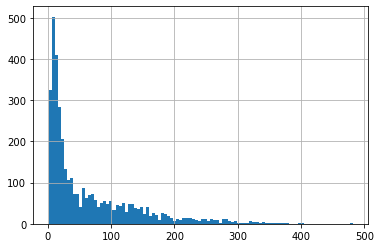

In [38]:
event_aggs['count'].hist(bins=100)

<AxesSubplot:>

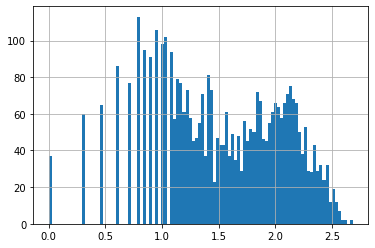

In [39]:
event_aggs['count'].transform(np.log10).hist(bins=100)

In [40]:
# how many units have 0 uptime?
len(cems.index.levels[0]) - len(events.index.levels[0])

565

In [41]:
events['duration'] = events['shutdown'] - events['startup']

In [42]:
# mean uptime duration, in hours
event_aggs['mean_duration'] = events['duration'].dt.total_seconds().div(60*60).groupby(level='unit_id_epa').mean()

In [48]:
event_aggs = events['duration'].dt.total_seconds().div(60*60).groupby(level='unit_id_epa').describe()
event_aggs

,count,mean,std,min,25%,50%,75%,max
unit_id_epa,,,,,,,,
1,6.0,179.666667,164.548676,6.0,70.50,140.5,252.50,454.0
2,8.0,116.000000,86.620684,2.0,71.00,130.0,142.00,274.0
4,12.0,238.166667,148.816442,7.0,155.25,211.5,350.75,506.0
5,11.0,517.181818,567.509263,4.0,14.50,326.0,813.00,1638.0
6,14.0,558.000000,701.084544,3.0,6.75,291.5,829.25,1983.0
...,...,...,...,...,...,...,...,...
91295,17.0,259.705882,332.795501,2.0,11.00,118.0,377.00,1150.0
91296,16.0,260.625000,235.627637,2.0,85.00,189.0,376.25,802.0
91299,22.0,5.909091,3.637229,2.0,3.00,4.5,7.00,15.0


<AxesSubplot:>

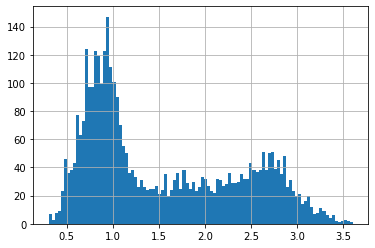

In [43]:
# log10 mean duration
event_aggs['mean_duration'].transform(np.log10).hist(bins=100)

<AxesSubplot:>

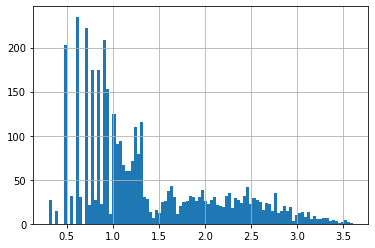

In [44]:
# log10 of median uptime duration, in hours
events['duration'].dt.total_seconds().div(60*60).groupby(level='unit_id_epa').median().transform(np.log10).hist(bins=100)

Is there a simple way to classify 'peakers' from 'baseload'? Is that distinction even meaningful?

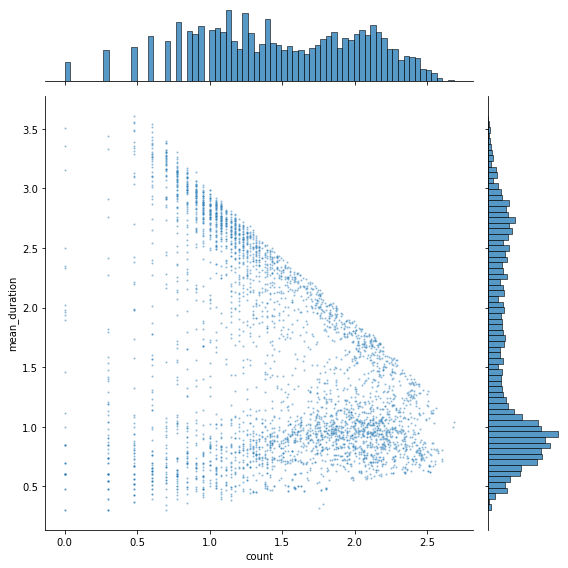

In [45]:
sns.jointplot(data=event_aggs.transform(np.log10), x='count', y='mean_duration', s=4, alpha=0.5, height=8, marginal_kws=dict(bins=70))

It looks like there are two fairly distinct populations of plants which look to be mostly linearly separable using only these two dimensions. But these two populations are NOT peakers vs baseload; these two populations are simply 'runs most hours' vs 'runs rarely'.

<AxesSubplot:>

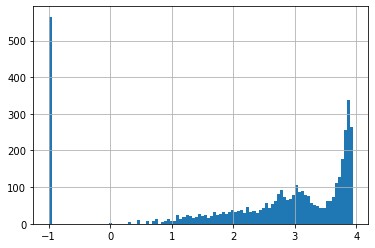

In [46]:
# log10 counts of non-zero generation hours, with 0 hours mapped to -1
cems['gross_load_mw'].gt(0).groupby(level='unit_id_epa').sum().replace(0, 1e-1).transform(np.log10).hist(bins=100)

I'll try calculating ramp rates and coloring the above plot by that.

The following was an attempt to convert event data back into timeseries. It failed due to performance issues with my implementation. I'm sure there is a way to do it, but I solved this problem by avoiding the events table entirely using the methods above.

In [301]:
raise Exception # stop 'run all cells' from continuing down

Exception: 

In [156]:
cems.loc[:,['hours_from_startup', 'hours_to_shutdown']] = np.nan

In [157]:
cems = cems.astype({'hours_from_startup': np.float32, 'hours_to_shutdown': np.float32}, copy=False)
cems.dtypes

operating_time_hours    float32
gross_load_mw           float32
load_factor             float32
hours_from_startup      float32
hours_to_shutdown       float32
dtype: object

In [158]:
hr = pd.Timedelta('1h')
min_timestamp = cems.index.levels[1][0]
max_timestamp = cems.index.levels[1][-1]
full_timeseries = pd.date_range(start=min_timestamp, end=max_timestamp, freq='h', tz='UTC').to_series()
idx = pd.IndexSlice

In [ ]:
# this doesn't work because it is horrifically inefficient. Something with the cems.loc[...] assignments
for index, ser in events.iterrows():
    # move bounds in by 1 hour because indexing is inclusive
    start = ser['startup'] + hr
    end = ser['shutdown'] - hr
    # if NaT, use first/last timestamp
    if start is pd.NaT:
        start = cems.loc[idx[1,:],:].index.get_level_values(level='operating_datetime_utc')[0]
    if end is pd.NaT:
        end = cems.loc[idx[1,:],:].index.get_level_values(level='operating_datetime_utc')[-1]
    
    from_startup = full_timeseries[start:end].sub(ser['startup']).dt.total_seconds().div(3600).to_numpy(dtype=np.float32) # hours
    to_shutdown = full_timeseries[start:end].sub(ser['shutdown']).dt.total_seconds().div(-3600).to_numpy(dtype=np.float32) # hours, .div(-3600) to fix sign
    
    cems.loc[idx[index[0], start:end], 'hours_from_startup'] = from_startup
    cems.loc[idx[index[0], start:end], 'hours_to_shutdown'] = to_shutdown
    #new_df = pd.DataFrame({'hours_from_startup': from_startup, 'hours_to_shutdown': to_shutdown}, index=cems.loc[idx[index[0], start:end],:].index)
    #cems.update(new_df)
    if index[0] > 10:
        break
    #subset = cems.loc[idx[index[0], start:end], ['hours_from_startup', 'hours_to_shutdown']]